# Making it Count

In [1]:
import pandas as pd
import numpy as np
import re
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

The main assignment for this week is to try and discover:

1. if there are any discourses that are distinctive of the early internet era versus the later web 2.0 era in the Humanist Listserv dataset.

2. visualize such differnce

### import

Creidts to the professor: [https://drive.google.com/drive/folders/1zNTPmQm_HtR1zeCpRAp3XSDBsZuZq0U5?usp=sharing](https://drive.google.com/drive/folders/1zNTPmQm_HtR1zeCpRAp3XSDBsZuZq0U5?usp=sharing). 

In [2]:
humanist = pd.read_csv(r'C:\Users\98768\Desktop\is310\inclass\text\web_scraped_humanist_listserv_volumes.csv')
humanist['period'] = pd.cut(humanist['inferred_start_year'], bins=[float('-inf'), 2000, 2010, 2020], 
                            labels=['early_internet', 'web_2.0', 'contemporary'])
humanist.head()

,volume_text,volume_link,volume_dates,volume_number,inferred_start_year,inferred_end_year,period
0,From: MCCARTY@UTOREPAS\nSubject: \nDate: 12 Ma...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1987-1988,1,1987,1988,early_internet
1,From: Sebastian Rahtz \nSubject: C++ and Gnu o...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1988-1989,2,1988,1989,early_internet
2,From: Willard McCarty \nSubject: Happy Birthda...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1989-1990,3,1989,1990,early_internet
3,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1990-1991,4,1990,1991,early_internet
4,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1991-1992,5,1991,1992,early_internet


In [3]:
early = humanist[humanist['period'] == 'early_internet'].reset_index(drop=True)
early.head()

,volume_text,volume_link,volume_dates,volume_number,inferred_start_year,inferred_end_year,period
0,From: MCCARTY@UTOREPAS\nSubject: \nDate: 12 Ma...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1987-1988,1,1987,1988,early_internet
1,From: Sebastian Rahtz \nSubject: C++ and Gnu o...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1988-1989,2,1988,1989,early_internet
2,From: Willard McCarty \nSubject: Happy Birthda...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1989-1990,3,1989,1990,early_internet
3,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1990-1991,4,1990,1991,early_internet
4,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1991-1992,5,1991,1992,early_internet


In [4]:
later = humanist[humanist['period'] != 'early_internet'].reset_index(drop=True)
later.head()

,volume_text,volume_link,volume_dates,volume_number,inferred_start_year,inferred_end_year,period
0,From: Willard McCarty \nSubject: 14\nDate: Mon...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,2001-2002,15,2001,2002,web_2.0
1,"From: NINCH-ANNOUNCE \nSubject: New Project: ""...",https://humanist.kdl.kcl.ac.uk/Archives/Conver...,2002-2003,16,2002,2003,web_2.0
2,From: Willard McCarty \nSubject: Happy Sweet 1...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,2003-2004,17,2003,2004,web_2.0
3,From: Willard McCarty \nSubject: happy 17th bi...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,2004-2005,18,2004,2005,web_2.0
4,From: Willard McCarty \nSubject: Happy 18th bi...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,2005-2006,19,2005,2006,web_2.0


### TF-IDF

lets try this out with my own data / humanist

In [5]:
# some helper functions

# here some specific definition of year, filtering and keep the other numbers, could be better
def indicate_year(term):
    if len(term) == 4:
        if term[0] + term[1] in ['17', '18', '19', '20']:
            if term[1:].isdigit():
                return 1
    return 0

# check if number, a stricter version of the previous function, but i guess i do not need this
def indicate_number(term):
    if len(term) == 4:
        if term.isdigit():
            return 1
    return 0

In [6]:
# early times
df = early
helper_fnc = indicate_year


documents = df['volume_text'].tolist()
vectorizer = TfidfVectorizer(max_df=.7, min_df=1, stop_words='english', lowercase=True)
transformed_documents = vectorizer.fit_transform(documents)

# top features for each document
transformed_documents_as_array = transformed_documents.toarray()

dates = df['inferred_start_year'].tolist()
tfidf_results = []

# Loop through each document and get the top terms
for counter, doc in enumerate(transformed_documents_as_array):
    # create a df with the top terms
    tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    one_doc_as_df['inferred_start_year'] = dates[counter]
    # create indicator for year
    one_doc_as_df['is_year'] = one_doc_as_df['term'].apply(helper_fnc)
    tfidf_results.append(one_doc_as_df)

tfidf_df = pd.concat(tfidf_results)
tfidf_df = tfidf_df.sort_values(by=['score'], ascending=False).reset_index(drop=True)
tfidf_df.head()

,term,score,inferred_start_year,is_year
0,http,0.737412,1998,0
1,http,0.732769,1997,0
2,http,0.731174,1999,0
3,http,0.714884,2000,0
4,http,0.695177,1996,0


In [7]:
# what we filtered out as years in the terms
np.sort(tfidf_df[tfidf_df['is_year'] == 1]['term'].unique())

array(['1701', '1702', '1703', '1704', '1705', '1706', '1707', '1708',
       '1709', '1710', '1711', '1712', '1713', '1714', '1715', '1716',
       '1717', '1718', '1719', '1720', '1721', '1722', '1723', '1724',
       '1725', '1726', '1727', '1728', '1729', '1730', '1731', '1732',
       '1733', '1734', '1735', '1736', '1737', '1738', '1739', '1740',
       '1741', '1742', '1743', '1744', '1745', '1746', '1747', '1748',
       '1749', '1751', '1752', '1753', '1754', '1755', '1756', '1757',
       '1758', '1759', '1760', '1761', '1762', '1763', '1764', '1765',
       '1766', '1767', '1768', '1769', '1770', '1771', '1772', '1773',
       '1774', '1775', '1776', '1777', '1778', '1779', '1780', '1781',
       '1782', '1783', '1784', '1785', '1786', '1787', '1788', '1791',
       '1792', '1793', '1794', '1795', '1796', '1797', '1798', '1801',
       '1802', '1803', '1804', '1805', '1806', '1807', '1808', '1809',
       '1810', '1811', '1812', '1813', '1814', '1815', '1816', '1817',
      

In [8]:
# what we keep
tfidf_df[tfidf_df['is_year'] == 0]['term'].value_counts()

http        14
espits      14
euroterm    14
erminer     14
prenne      14
            ..
jericho     14
mappiq      14
frsim51     14
txtout13    14
brunei      14
Name: term, Length: 115814, dtype: int64

In [9]:
# fraction of loss
tfidf_df[tfidf_df['is_year'] == 1].shape[0] / tfidf_df.shape[0]

0.0026953249459643323

In [10]:
data = tfidf_df[tfidf_df['is_year'] == 0].reset_index(drop=True).head(200)
selection = alt.selection_point(fields=['term'], bind='legend')

chart = alt.Chart(data).mark_bar().encode(
    y='score',
    x=alt.X('inferred_start_year:N', axis=alt.Axis(labelAngle=-45)),
    color=alt.Color('term', legend=alt.Legend(title='Term', orient='right', symbolLimit=len(data['term'].unique()), columns=5), scale=alt.Scale(scheme='tableau20')),
    tooltip=['term', 'score', 'year(inferred_start_year)'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_params(selection).properties(
    title='Top 200 Terms by TF-IDF Score in Humanist Volumes before 2000'
)

chart

alt.Chart(...)

late times

In [11]:
df = later
helper_fnc = indicate_year


documents = df['volume_text'].tolist()
vectorizer = TfidfVectorizer(max_df=.7, min_df=1, stop_words='english', lowercase=True)
transformed_documents = vectorizer.fit_transform(documents)

# top features for each document
transformed_documents_as_array = transformed_documents.toarray()

dates = df['inferred_start_year'].tolist()
tfidf_results = []

# Loop through each document and get the top terms
for counter, doc in enumerate(transformed_documents_as_array):
    # create a df with the top terms
    tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    one_doc_as_df['inferred_start_year'] = dates[counter]
    # create indicator for year
    one_doc_as_df['is_year'] = one_doc_as_df['term'].apply(helper_fnc)
    tfidf_results.append(one_doc_as_df)

tfidf_df = pd.concat(tfidf_results)
tfidf_df = tfidf_df.sort_values(by=['score'], ascending=False).reset_index(drop=True)
tfidf_df.head()

,term,score,inferred_start_year,is_year
0,num,0.759407,2004,0
1,num,0.748565,2007,0
2,num,0.739062,2006,0
3,num,0.735991,2003,0
4,num,0.698540,2005,0


In [12]:
data = tfidf_df[tfidf_df['is_year'] == 0].reset_index(drop=True).head(200)
selection = alt.selection_point(fields=['term'], bind='legend')

chart = alt.Chart(data).mark_bar().encode(
    y='score',
    x=alt.X('inferred_start_year:N', axis=alt.Axis(labelAngle=-45)),
    color=alt.Color('term', legend=alt.Legend(title='Term', orient='right', symbolLimit=len(data['term'].unique()), columns=5), scale=alt.Scale(scheme='tableau20')),
    tooltip=['term', 'score', 'year(inferred_start_year)'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_params(selection).properties(
    title='Top 200 Terms by TF-IDF Score in Humanist Volumes after 2000'
)

chart

alt.Chart(...)

### Classification SVM

In [13]:
df = humanist
helper_fnc = indicate_year


documents = df['volume_text'].tolist()
vectorizer = TfidfVectorizer(max_df=.7, min_df=1, stop_words='english', lowercase=True)
transformed_documents = vectorizer.fit_transform(documents)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(transformed_documents, df['period'], test_size=0.2, random_state=0)

# Train a logistic regression classifier
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)

# Predict the time period of the test set
y_pred = clf.predict(X_test)

c:\Users\98768\Desktop\is310\is310-env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


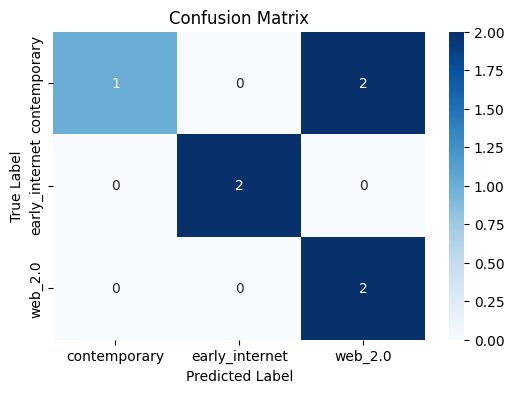

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
coefficients = clf.coef_
terms = vectorizer.get_feature_names_out()

terms_df = pd.DataFrame({'term': terms, 
                         'contemporary': coefficients[0], 
                         'early_internet': coefficients[1], 
                         'web_2.0': coefficients[2]})
top_terms = terms_df.melt(id_vars='term', var_name='period', value_name='coefficient') \
                        .sort_values(by='coefficient', ascending=False).groupby('period').head(10).reset_index(drop=True)
top_terms

,term,period,coefficient
0,digitalhumanities,contemporary,0.876648
1,joyent,web_2.0,0.778521
2,s16382816,contemporary,0.722179
3,onlinehome,contemporary,0.722179
4,bitnet,early_internet,0.627022
5,woodward,web_2.0,0.533093
6,2004,web_2.0,0.492034
7,ubiquity,web_2.0,0.481175
8,2007,web_2.0,0.451699
9,2009,web_2.0,0.446021


In [16]:
# visualize top terms
top_terms['period'] = top_terms['period'].astype(str)
selection = alt.selection_point(fields=['term'], bind='legend')

# Define the sort order for the periods
period_order = ['early_internet', 'web_2.0', 'contemporary']

chart = alt.Chart(top_terms).mark_bar().encode(
    x=alt.X('period', sort=['early_internet', 'web_2.0', 'contemporary'], axis=alt.Axis(title='Period')),
    y=alt.Y('coefficient:Q'),  # Sort terms by score in descending order
    color=alt.Color('term', legend=alt.Legend(title='Term', orient='right', symbolLimit=len(top_terms['term'].unique()), columns=5), scale=alt.Scale(scheme='tableau20')),
    tooltip=['term', 'coefficient', 'period'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_params(selection).properties(
    title='Top 10 Terms by Coefficient in Logistic Regression Model by Period'
)
chart

alt.Chart(...)